# Coronavirus tweets NLP - Text Classification

In [480]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [528]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Input,GlobalMaxPool1D,Embedding,GlobalMaxPooling1D,GRU
from sklearn.metrics import classification_report,roc_auc_score
from nltk.stem import WordNetLemmatizer

## Importing Data

In [482]:
df=pd.read_csv('Corona_NLP_test.csv')

In [483]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [484]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [485]:
df.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

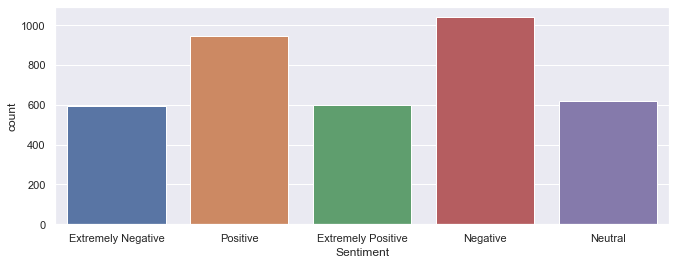

In [486]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(df['Sentiment'])

In [487]:
df['OriginalTweet']

0       TRENDING: New Yorkers encounter empty supermar...
1       When I couldn't find hand sanitizer at Fred Me...
2       Find out how you can protect yourself and love...
3       #Panic buying hits #NewYork City as anxious sh...
4       #toiletpaper #dunnypaper #coronavirus #coronav...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 3798, dtype: object

In [488]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [489]:
df['Sentiment']=df['Sentiment'].apply(lambda x: change_sen(x))

### Replacing punctuations with space

In [490]:
df['OriginalTweet_processed']=df['OriginalTweet'].str.replace('http',' ')
df['OriginalTweet_processed']=df['OriginalTweet'].str.replace("[^a-zA-Z0-9]", " ") 

In [491]:
df['OriginalTweet_processed']

0       TRENDING  New Yorkers encounter empty supermar...
1       When I couldn t find hand sanitizer at Fred Me...
2       Find out how you can protect yourself and love...
3        Panic buying hits  NewYork City as anxious sh...
4        toiletpaper  dunnypaper  coronavirus  coronav...
                              ...                        
3793    Meanwhile In A Supermarket in Israel    People...
3794    Did you panic buy a lot of non perishable item...
3795    Asst Prof of Economics  cconces was on  NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and  ForestandPaper members are committed to...
Name: OriginalTweet_processed, Length: 3798, dtype: object

### Replacing short words

In [492]:
df['OriginalTweet_processed']=df['OriginalTweet_processed'].apply(lambda row:' '.join([word for word in row.split() if len(word)>2]))

In [493]:
df['OriginalTweet_processed']

0       TRENDING New Yorkers encounter empty supermark...
1       When couldn find hand sanitizer Fred Meyer tur...
2       Find out how you can protect yourself and love...
3       Panic buying hits NewYork City anxious shopper...
4       toiletpaper dunnypaper coronavirus coronavirus...
                              ...                        
3793    Meanwhile Supermarket Israel People dance and ...
3794    Did you panic buy lot non perishable items ECH...
3795    Asst Prof Economics cconces was NBCPhiladelphi...
3796    Gov need somethings instead biar rakyat assume...
3797    and ForestandPaper members are committed the s...
Name: OriginalTweet_processed, Length: 3798, dtype: object

### Remove stop words

In [494]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [495]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [496]:
def clean_text(text):
    text=text.split()
    text=' '.join([word for word in text if word.lower() not in stop_words])
    return text

In [497]:
df['OriginalTweet_processed']=df['OriginalTweet_processed'].apply(lambda x : clean_text(x))

In [498]:
df['OriginalTweet_processed']

0       TRENDING New Yorkers encounter empty supermark...
1       find hand sanitizer Fred Meyer turned Amazon 1...
2                     Find protect loved ones coronavirus
3       Panic buying hits NewYork City anxious shopper...
4       toiletpaper dunnypaper coronavirus coronavirus...
                              ...                        
3793    Meanwhile Supermarket Israel People dance sing...
3794    panic buy lot non perishable items ECHO needs ...
3795    Asst Prof Economics cconces NBCPhiladelphia ta...
3796    Gov need somethings instead biar rakyat assume...
3797    ForestandPaper members committed safety employ...
Name: OriginalTweet_processed, Length: 3798, dtype: object

In [499]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_processed
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,negative,TRENDING New Yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,positive,find hand sanitizer Fred Meyer turned Amazon 1...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,positive,Find protect loved ones coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,negative,Panic buying hits NewYork City anxious shopper...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,netural,toiletpaper dunnypaper coronavirus coronavirus...


## Encoding the label

In [500]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()

df['Sentiment']=label_encoder.fit_transform(df['Sentiment'])

In [501]:
df['Sentiment'].unique()

array([0, 2, 1])

### Splitting the Data

In [502]:
from sklearn.model_selection import train_test_split
X=df['OriginalTweet_processed']
y=df['Sentiment']

In [503]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Tokenization

In [504]:
lemmatizer=WordNetLemmatizer()

In [505]:
tokenizer=Tokenizer(num_words=20000,oov_token=lemmatizer)
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

In [506]:
word_to_index=tokenizer.word_index
len(word_to_index)

10607

### Padding

In [520]:
X_train=pad_sequences(X_train,maxlen=60,padding='post',truncating='post')
T=X_train.shape
T=T[1]

In [521]:
X_test=pad_sequences(X_test,maxlen=60,padding='post',truncating='post')
X_test.shape

(1140, 60)

## LSTM Model

In [509]:
# ** Embeddindg Dimentionality **

D=32

# Its an hyper aparameter ( Length of word in sentence want to select)

# Hidden state dimentionality (M)

M=60

# Size of embedding should be (V+1 x D )
# Because first index start from 1 not from 0
# So if final index of embedding metrix is V then it should be V+1

V=len(word_to_index)

In [510]:
model=Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V+1,D))
model.add(LSTM(M,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(M))
model.add(Dense(3,activation='softmax'))

In [511]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [512]:
early_stop=EarlyStopping(monitor='val_accuracy',patience=10)
reduceLR=ReduceLROnPlateau(monitor='val_accuarcy',patience=8)

In [513]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [514]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=50,batch_size=64,callbacks=[early_stop,reduceLR])

Epoch 1/50
42/42 [==============================] - 6s 71ms/step - loss: 1.0357 - accuracy: 0.4191 - val_loss: 1.0201 - val_accuracy: 0.4237 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 2s 53ms/step - loss: 0.9506 - accuracy: 0.4868 - val_loss: 0.9311 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 2s 50ms/step - loss: 0.6449 - accuracy: 0.7491 - val_loss: 0.8818 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 2s 50ms/step - loss: 0.2494 - accuracy: 0.9229 - val_loss: 1.1982 - val_accuracy: 0.6307 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 2s 50ms/step - loss: 0.0789 - accuracy: 0.9778 - val_loss: 1.3290 - val_accuracy: 0.6254 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 2s 52ms/step - loss: 0.0459 - accuracy: 0.9876 - val_loss: 1.4727 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 2s 49ms/step - loss: 0.0

In [516]:
# Model 2

In [515]:
model=Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V+1,D))
model.add(LSTM(M,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(M,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=50,batch_size=64,callbacks=[early_stop,reduceLR])

Epoch 1/50
42/42 [==============================] - 6s 64ms/step - loss: 1.0469 - accuracy: 0.4206 - val_loss: 1.0295 - val_accuracy: 0.4237 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 2s 48ms/step - loss: 1.0041 - accuracy: 0.4628 - val_loss: 0.9713 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 2s 53ms/step - loss: 0.8500 - accuracy: 0.5700 - val_loss: 0.9441 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 2s 51ms/step - loss: 0.5334 - accuracy: 0.7912 - val_loss: 1.0185 - val_accuracy: 0.5912 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 2s 50ms/step - loss: 0.2580 - accuracy: 0.9229 - val_loss: 1.2326 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 2s 50ms/step - loss: 0.1349 - accuracy: 0.9643 - val_loss: 1.4610 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 2s 50ms/step - loss: 0.0

In [517]:
#model 3

In [519]:
model=Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V+1,D))
model.add(LSTM(M))
model.add(Dense(M,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=50,batch_size=64,callbacks=[early_stop])

Epoch 1/50
42/42 [==============================] - 5s 64ms/step - loss: 1.0473 - accuracy: 0.4236 - val_loss: 1.0352 - val_accuracy: 0.4237
Epoch 2/50
42/42 [==============================] - 2s 47ms/step - loss: 1.0262 - accuracy: 0.4330 - val_loss: 1.0323 - val_accuracy: 0.4237
Epoch 3/50
42/42 [==============================] - 2s 52ms/step - loss: 1.0136 - accuracy: 0.4334 - val_loss: 0.9592 - val_accuracy: 0.4491
Epoch 4/50
42/42 [==============================] - 2s 48ms/step - loss: 0.9359 - accuracy: 0.4819 - val_loss: 0.9744 - val_accuracy: 0.4763
Epoch 5/50
42/42 [==============================] - 2s 46ms/step - loss: 0.8339 - accuracy: 0.5260 - val_loss: 1.0080 - val_accuracy: 0.4561
Epoch 6/50
42/42 [==============================] - 2s 47ms/step - loss: 0.7836 - accuracy: 0.5598 - val_loss: 1.0729 - val_accuracy: 0.4719
Epoch 7/50
42/42 [==============================] - 2s 46ms/step - loss: 0.7095 - accuracy: 0.5877 - val_loss: 0.9865 - val_accuracy: 0.4632
Epoch 8/50
42

In [527]:
model=Sequential()
model.add(Input(shape=(60,)))
model.add(Embedding(V+1,D))
model.add(LSTM(M,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(M))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=50,batch_size=64,callbacks=[early_stop])

Epoch 1/50
42/42 [==============================] - 6s 83ms/step - loss: 1.0322 - accuracy: 0.4424 - val_loss: 1.0218 - val_accuracy: 0.4693
Epoch 2/50
42/42 [==============================] - 3s 66ms/step - loss: 0.9813 - accuracy: 0.4707 - val_loss: 0.9771 - val_accuracy: 0.4298
Epoch 3/50
42/42 [==============================] - 3s 68ms/step - loss: 0.7765 - accuracy: 0.6099 - val_loss: 0.9810 - val_accuracy: 0.5667
Epoch 4/50
42/42 [==============================] - 3s 71ms/step - loss: 0.4374 - accuracy: 0.8269 - val_loss: 1.2462 - val_accuracy: 0.5956
Epoch 5/50
42/42 [==============================] - 3s 67ms/step - loss: 0.1771 - accuracy: 0.9375 - val_loss: 1.5150 - val_accuracy: 0.5860
Epoch 6/50
42/42 [==============================] - 3s 67ms/step - loss: 0.0994 - accuracy: 0.9695 - val_loss: 1.8720 - val_accuracy: 0.6026
Epoch 7/50
42/42 [==============================] - 3s 68ms/step - loss: 0.0474 - accuracy: 0.9895 - val_loss: 2.5624 - val_accuracy: 0.6202
Epoch 8/50
42

In [530]:
model=Sequential()
model.add(Input(shape=(60,)))
model.add(Embedding(V+1,D))
model.add(GRU(M,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(M))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=50,batch_size=64,callbacks=[early_stop])

Epoch 1/50
42/42 [==============================] - 7s 97ms/step - loss: 1.0200 - accuracy: 0.4323 - val_loss: 1.0171 - val_accuracy: 0.4509
Epoch 2/50
42/42 [==============================] - 3s 61ms/step - loss: 0.9588 - accuracy: 0.5816 - val_loss: 0.9380 - val_accuracy: 0.5667
Epoch 3/50
42/42 [==============================] - 3s 63ms/step - loss: 0.6920 - accuracy: 0.7412 - val_loss: 0.8568 - val_accuracy: 0.6526
Epoch 4/50
42/42 [==============================] - 3s 64ms/step - loss: 0.2699 - accuracy: 0.9123 - val_loss: 0.9891 - val_accuracy: 0.6500
Epoch 5/50
42/42 [==============================] - 3s 62ms/step - loss: 0.0949 - accuracy: 0.9748 - val_loss: 1.3223 - val_accuracy: 0.6553
Epoch 6/50
42/42 [==============================] - 3s 63ms/step - loss: 0.0323 - accuracy: 0.9921 - val_loss: 2.0023 - val_accuracy: 0.6500
Epoch 7/50
42/42 [==============================] - 3s 61ms/step - loss: 0.0165 - accuracy: 0.9970 - val_loss: 2.0660 - val_accuracy: 0.6325
Epoch 8/50
42